In [1]:
import warnings
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, accuracy_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, FunctionTransformer
from skorch.callbacks import Callback, ProgressBar
from skorch.net import NeuralNet
import matplotlib.pyplot as plt
import torch
from torch import nn

In [152]:
start_df = pd.read_csv('Data/post_feat_analysis_health_behaviour.csv')

In [153]:
start_df.head()

,_STATE,STRFREQ_,GENHLTH,EXRACT11,ACTIN12_,EXRACT21,PAFREQ2_,_MINAC21,ACTIN22_,PA2MIN_,_BMI5,_RFSMOK3,FTJUDA2_,_FRUTSU1,_VEGESU1,_PAINDX2,_PASTRNG,_EDUCAG,INCOME2
0,1.0,0.0,4.0,64.0,1.0,73.0,5.000,750.0,1.0,778.0,18.54,1.0,0.00,1.00,1.21,1.0,2.0,3.0,5.0
1,1.0,2.0,3.0,2.0,2.0,64.0,1.167,70.0,1.0,190.0,31.62,1.0,0.14,1.14,1.64,1.0,1.0,4.0,7.0
2,1.0,3.0,2.0,98.0,2.0,73.0,3.000,90.0,1.0,270.0,32.98,2.0,0.20,1.20,1.34,1.0,1.0,4.0,7.0
3,1.0,3.0,2.0,64.0,1.0,18.0,0.467,84.0,2.0,468.0,22.31,2.0,0.00,2.00,3.10,1.0,1.0,4.0,7.0
4,1.0,0.0,1.0,64.0,2.0,18.0,4.000,720.0,2.0,1920.0,25.79,1.0,1.00,2.00,1.79,1.0,2.0,4.0,8.0


In [154]:
start_df.columns

Index(['_STATE', 'STRFREQ_', 'GENHLTH', 'EXRACT11', 'ACTIN12_', 'EXRACT21',
       'PAFREQ2_', '_MINAC21', 'ACTIN22_', 'PA2MIN_', '_BMI5', '_RFSMOK3',
       'FTJUDA2_', '_FRUTSU1', '_VEGESU1', '_PAINDX2', '_PASTRNG', '_EDUCAG',
       'INCOME2'],
      dtype='object')

In [155]:
#pull only features with sig Chi square > 200
#df = df[['GENHLTH','_BMI5','ACTIN12_', 'ACTIN22_', '_RFSMOK3','_PASTRNG', 'INCOME2', '_EDUCAG', '_STATE', 'EXRACT21', '_PAINDX2']].copy()

In [156]:
df = start_df[['GENHLTH', 'INCOME2', '_BMI5', '_EDUCAG', '_RFSMOK3', 'STRFREQ_']].copy()

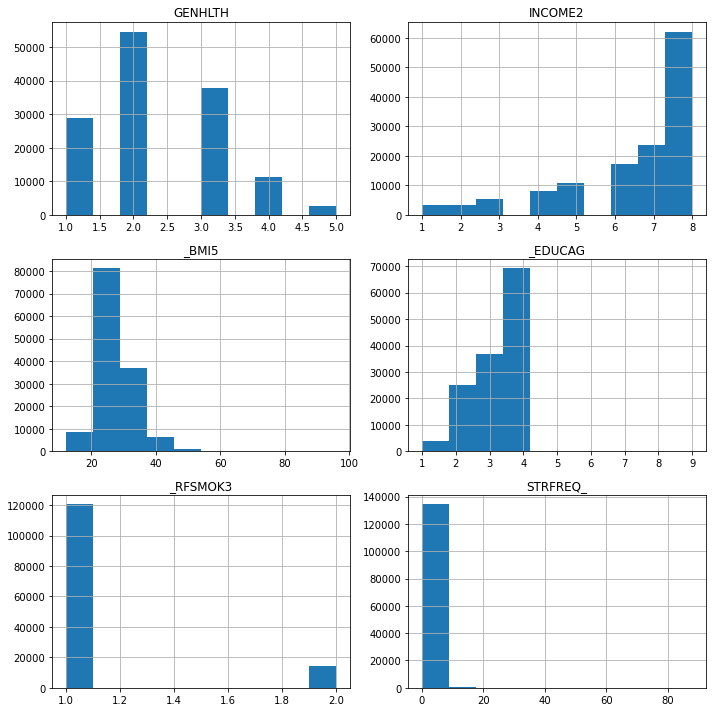

In [157]:
#now look at distributions of the features
df.hist(figsize=(10, 10));
plt.tight_layout();

In [112]:
#Look more closely at the features with odd ranges
#check the distribution of target
#feat = df['PAFREQ2_']
#(feat.value_counts()
#  .sort_index()
#  .plot(kind='bar'));
#plt.ylabel('Counts');
#plt.xlabel('PAFREQ2_');

In [113]:
#df['PAFREQ2_'].max() - df['PAFREQ2_'].min() 

In [94]:
#looks like there are quite a few extreme outliers in several columns, this aligns with what I noticed earlier

In [158]:
#remove all outliers
from scipy import stats
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
df = df.dropna(how="any")

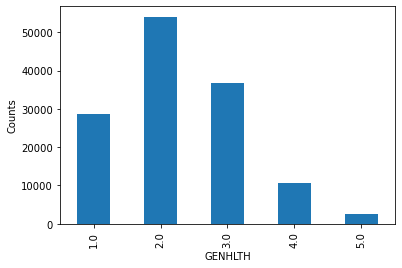

In [159]:
#check the distribution of target
y = df.pop('GENHLTH')
(y.value_counts()
  .sort_index()
  .plot(kind='bar'));
plt.ylabel('Counts');
plt.xlabel('GENHLTH');

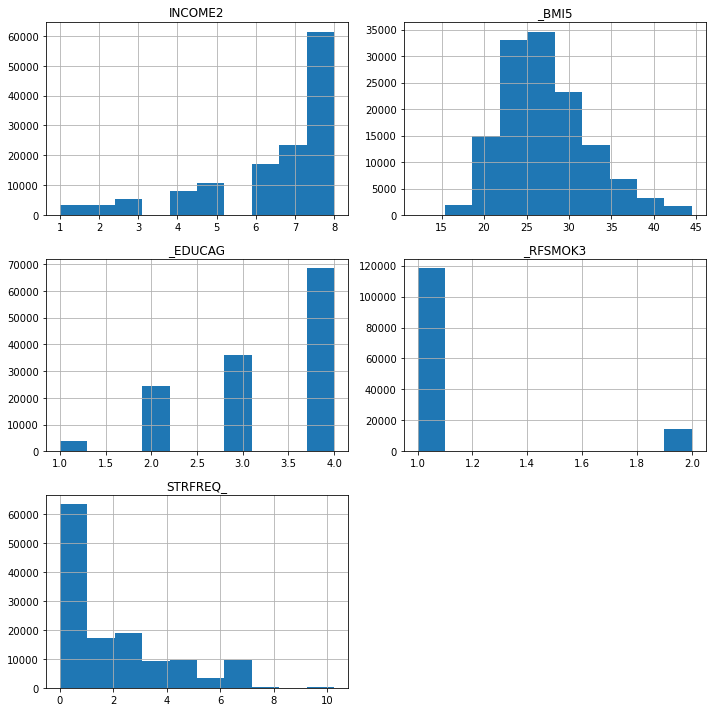

In [160]:
#look at distributions of the features again
df.hist(figsize=(10, 10));
plt.tight_layout();

In [163]:
#Use standard scaler on the more gaussian-like columns and power transformer on the others

gaussian_columns = ['_BMI5'] #'_STATE', 'ACTIN12_', 'EXRACT21', 'ACTIN22_', 
power_columns = ['_RFSMOK3', '_EDUCAG', 'INCOME2', 'STRFREQ_'] # '_PAINDX2', '_PASTRNG', 
column_transformer = ColumnTransformer([
    ('gaussian', StandardScaler(), gaussian_columns),
    ('power', PowerTransformer(), power_columns)
])

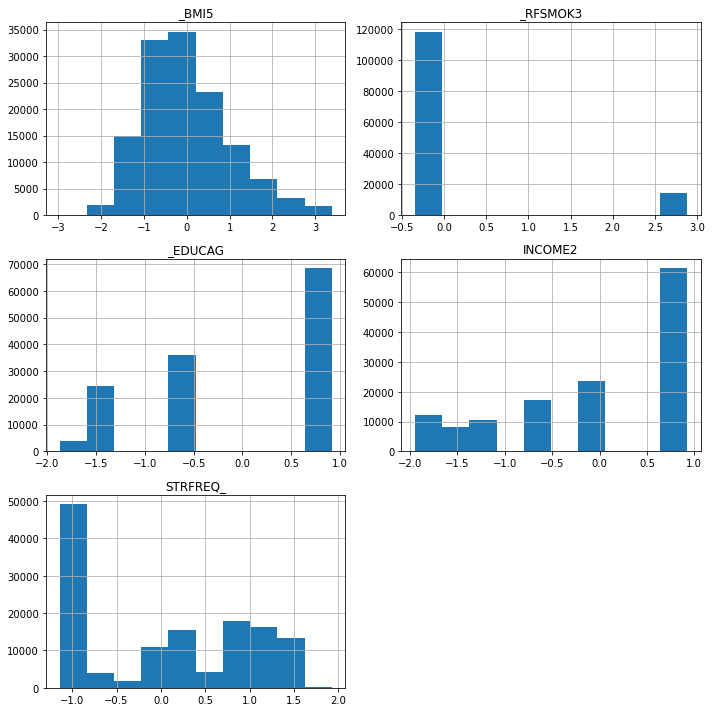

In [164]:
X_trans = column_transformer.fit_transform(df)
(pd.DataFrame(X_trans,
              columns= gaussian_columns + power_columns)
   .hist(figsize=(10, 10)));
plt.tight_layout();

In [165]:
#fit to scale and split data
y = y.values.astype(np.long).reshape(-1, 1)
# Map y from (3-8) to (0-5)
y -= y.min()

X = df

(X_train, X_test,
 y_train, y_test) = train_test_split(X, y, test_size=0.33,
                                     stratify=y, random_state=666)

In [166]:
#Develop pipeline
from mord.threshold_based import LogisticAT, LogisticIT

pipeline = Pipeline([
    ('column', column_transformer),
    ('caster', FunctionTransformer(to_float)),
    ('model', LogisticIT())
])

In [167]:
param_grid = {
    'model__max_iter': np.logspace(3, 5, 5).astype(int),
    'model__alpha': np.logspace(0, 4, 5)
}

mord_grid_search = GridSearchCV(
    pipeline, param_grid, scoring=scoring,
    n_jobs=None, cv=5, verbose=1
)
mord_grid_search.fit(X_train, y_train.ravel()) #added ravel after warning appeared as my y_train was a numpy_array (column vector) and not a 1d array

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column',
                                        ColumnTransformer(transformers=[('gaussian',
                                                                         StandardScaler(),
                                                                         ['_BMI5']),
                                                                        ('power',
                                                                         PowerTransformer(),
                                                                         ['_RFSMOK3',
                                                                          '_EDUCAG',
                                                                          'INCOME2',
                                                                          'STRFREQ_'])])),
                                       ('caster',
                                        FunctionTransformer(func=<function to_float at 0x000001A50

In [168]:
cutpoints = (mord_grid_search
             .best_estimator_
             .named_steps['model']
             .theta_)
print(f"Cutpoints: {cutpoints}")

Cutpoints: [-0.79242513  0.42396909  1.50389924  1.92084376]


In [169]:
y_pred = mord_grid_search.predict(X_test)

In [125]:
#Results from LogisticAT (All-threshold)
#bins = np.arange(6)
#plt.hist(y_test, bins=bins, alpha=0.5);
#plt.hist(y_pred, bins=bins, alpha=0.5);
#plt.legend(['y_true', 'y_pred']);
#plt.ylabel('Counts');
#plt.xlabel('Ordinal Class');
#plt.title('LogisticAT mord Class Distributions');

In [126]:
#print(f'LogisticAT accuracy = {accuracy_score(y_test, y_pred):1.3f}')
#print(f'LogisticAT MSE = {mean_absolute_error(y_test, y_pred):1.3f}')

In [127]:
#LogisticAT_matrix = confusion_matrix(y_test, y_pred)
#print(f"Logistic Ordinal Regression, All-Threshold: {LogisticAT_matrix}")

In [128]:
#LogisticAT_report = classification_report(y_test, y_pred, zero_division = 1)
#print(f"Logistic Ordinal Regression, All-Threshold: {LogisticAT_report}")

In [129]:
#LogisticAT_r_square = r2_score(y_test, y_pred)
#print(f"Logistic Ordinal Regression, All-Threshold R squared: {LogisticAT_r_square}")

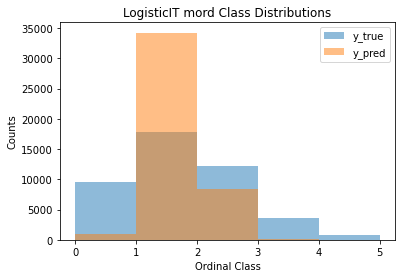

In [170]:
#Results from LogisticIT (Immediate-threshold)
bins = np.arange(6)
plt.hist(y_test, bins=bins, alpha=0.5);
plt.hist(y_pred, bins=bins, alpha=0.5);
plt.legend(['y_true', 'y_pred']);
plt.ylabel('Counts');
plt.xlabel('Ordinal Class');
plt.title('LogisticIT mord Class Distributions');

In [171]:
print(f'LogisticIT accuracy = {accuracy_score(y_test, y_pred):1.3f}')
print(f'LogisticIT MSE = {mean_absolute_error(y_test, y_pred):1.3f}')

LogisticIT accuracy = 0.431
LogisticIT MSE = 0.661


In [172]:
LogisticIT_matrix = confusion_matrix(y_test, y_pred)
print(f"Logistic Ordinal Regression, Immediate-Threshold: {LogisticIT_matrix}")

Logistic Ordinal Regression, Immediate-Threshold: [[  458  8318   695     7     0]
 [  377 14977  2468    14     0]
 [  103  8615  3385    37     2]
 [   28  1949  1499    47     2]
 [    6   391   404    11     1]]


In [173]:
LogisticIT_report = classification_report(y_test, y_pred, zero_division = 1)
print(f"Logistic Ordinal Regression, Immediate--Threshold: {LogisticIT_report}")

Logistic Ordinal Regression, Immediate--Threshold:               precision    recall  f1-score   support

           0       0.47      0.05      0.09      9478
           1       0.44      0.84      0.58     17836
           2       0.40      0.28      0.33     12142
           3       0.41      0.01      0.03      3525
           4       0.20      0.00      0.00       813

    accuracy                           0.43     43794
   macro avg       0.38      0.24      0.20     43794
weighted avg       0.43      0.43      0.35     43794



In [174]:
LogisticIT_r_square = r2_score(y_test, y_pred)
print("R-squared:")
print(f"Logistic Ordinal Regression, Immediate-Threshold: {LogisticIT_r_square}")

R-squared:
Logistic Ordinal Regression, Immediate-Threshold: 0.04385525737321183
